#### Routing to Datasources

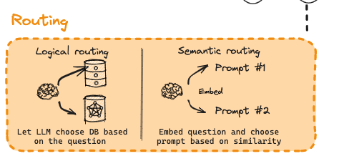

In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
import os
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

##### Logical and Semantic Routing

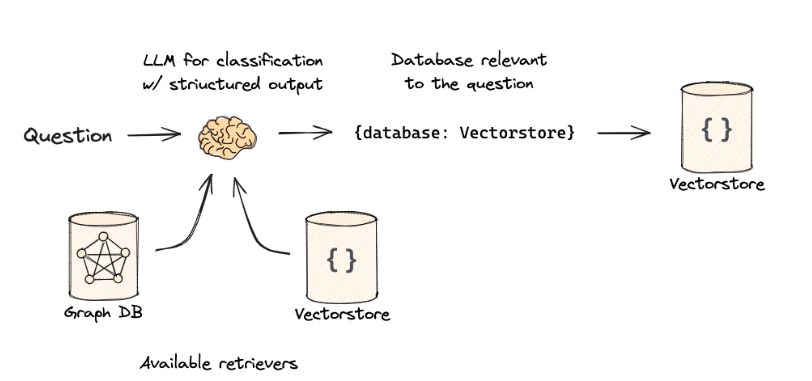

- Logical Routing

In [3]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel,Field

# Data model --> ... means the field is required
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call 
llm = ChatGroq(temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to the appropriate data source.
Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router_chain = prompt | structured_llm

c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


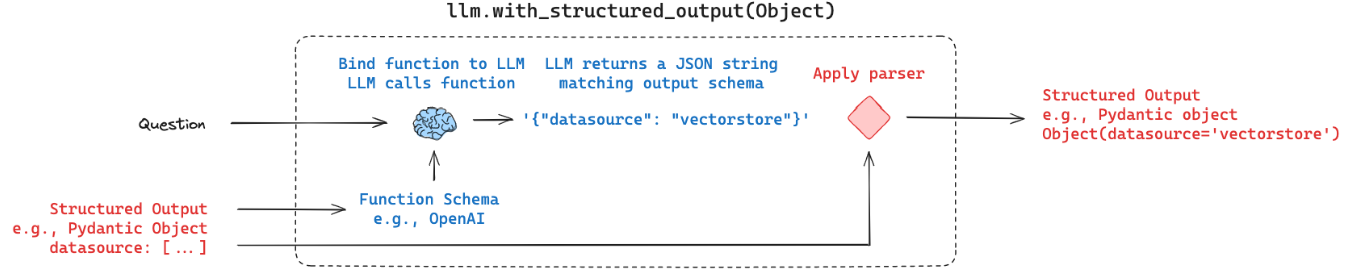

In [4]:
# the router chain will route the question to appropriate datasource.

In [4]:
question = """
Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""
result = router_chain.invoke({"question":question})

In [5]:
result

RouteQuery(datasource='python_docs')

In [6]:
result.datasource

'python_docs'

In [7]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        return "chain for js_docs"
    else:
        return "chain for golang_docs"

In [8]:
# the router_chain will provide us the datasource need to use
# then data output is passed to the full_router_chain, which will perform further retrieval operations.

In [9]:
from langchain_core.runnables import RunnableLambda

full_router_chain = (
    router_chain
    | RunnableLambda(choose_route)
)
result = full_router_chain.invoke({"question":question})
print(result)

chain for python_docs


- Semantic Routing

In [10]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

prompt_templates = [math_template,physics_template]
prompt_embeddings = hf_embeddings.embed_documents(prompt_templates)

def prompt_router(input):
    embed_query = hf_embeddings.embed_query(input["query"])
    similarity = cosine_similarity([embed_query],prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)

prompt_router_chain = (
    {"query":RunnablePassthrough()}
    | RunnableLambda(prompt_router) # This line of code passing the prompt to the LLM model
    | ChatGroq(temperature=0)
    | StrOutputParser()
)

prompt_router_chain.invoke("What is the boiling point of the water ?")

c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PHYSICS


'The boiling point of water is 100 degrees Celsius or 212 degrees Fahrenheit at standard atmospheric pressure, which is defined as 1 atmosphere (atm). However, this value can vary depending on the altitude and the atmospheric pressure at that location. For example, at higher altitudes, where the pressure is lower, water boils at a lower temperature.'